# Ordinal analysis of the MTurk Experiment (non-centered)

In [1]:
# %load std_ipython_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pymc3 as pm
import theano.tensor as tt

from theano.compile.ops import as_op
from scipy.stats import norm
from scipy.stats import t as studentT
from matplotlib import gridspec
from matplotlib.patches import Rectangle
from IPython.display import Image
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

%matplotlib inline
plt.style.use('seaborn-white')


from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Gill Sans MT']


/Users/harisundaram/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Data

In [4]:
# Using dtype 'category' for Y
df = pd.read_csv(
    'data/all_item_output_926.csv',
    dtype={
        'y': 'int',
        'gesture': 'int',
        'dist': 'int',
        'shading': 'int',
        'cond': 'int',
        'comicleft': 'int'
    })
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 655 entries, 0 to 654
Data columns (total 6 columns):
gesture      655 non-null int64
dist         655 non-null int64
shading      655 non-null int64
y            655 non-null int64
cond         655 non-null int64
comicleft    655 non-null int64
dtypes: int64(6)
memory usage: 30.8 KB


In [5]:
# defining some temp variables for the least squares estimate.
X = df[['gesture', 'dist', 'shading', 'cond', 'comicleft']]
X_i = (X - X.mean())/X.std() # predictors
Y_r = (df['y'] + 4).values # to create a response variable
X_i['c'] = 1
X_i = X_i.reindex(columns=['c', 'gesture', 'dist', 'shading', 'cond', 'comicleft'])
[beta_test_val, residual, rank, eig] = np.linalg.lstsq(X_i, Y_r, rcond=None)

In [6]:
eig

array([27.00611789, 26.33067318, 25.59296778, 25.40641385, 24.83253889,
       24.19141158])

In [7]:
df['y'] = (df['y'] + 4).astype('category') # changing the range to 1-7
dfpos = df[df.cond==1]
dfneg = df[df.cond==0]

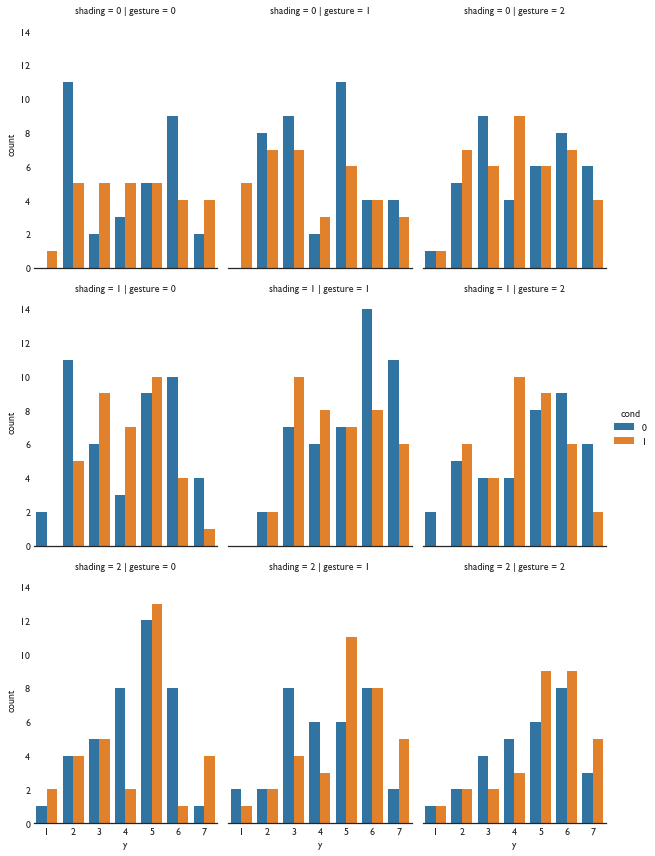

In [7]:
g = sb.factorplot(
    x="y",
    hue="cond",
    col="gesture",
    row="shading",
    data=df,
    kind="count",
    size=4,
    aspect=0.7)
g.despine(left=True)
g.savefig("condition-gesture-shading-counts.pdf")

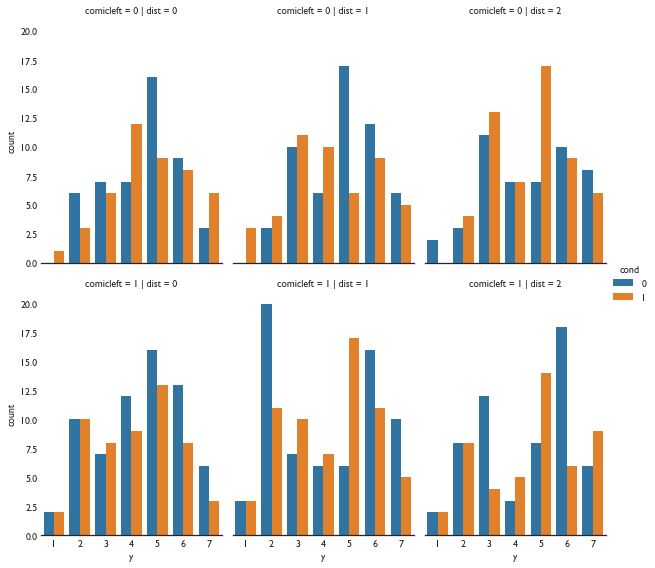

In [8]:
g = sb.factorplot(
    x="y",
    hue="cond",
    col="dist",
    row="comicleft",
    data=df,
    kind="count",
    size=4,
    aspect=0.7)
g.despine(left=True)
g.savefig("condition-dist-counts.pdf")

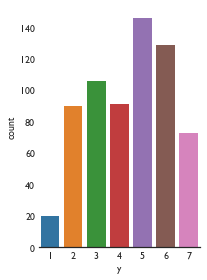

In [10]:
g = sb.factorplot(
    x="y",
    data=df,
    kind="count",
    size=4,
    aspect=0.7)
g.despine(left=True)
g.savefig("counts-main.pdf")

In [8]:
y_cat = (df['y']).astype('category')  # in range 1-7
nYlevels = y_cat.nunique()

In [9]:
sd_X = X.std()
mean_X = X.mean()
zX = (X - mean_X)/sd_X
# zX = X # don't normalize because all values are between 0-2

In [10]:
nYlevels4 = y_cat.nunique()

thresh4 = [k + 0.5
           for k in range(1, nYlevels4)]  # fixing the boundaries in our case
thresh_obs4 = np.ma.asarray(thresh4)
thresh_obs4[1:-1] = np.ma.masked

print('thresh4:\t{}'.format(thresh4))
print('thresh_obs4:\t{}'.format(thresh_obs4))

pr_test_val = df.groupby('y').size()/df.shape[0]

thresh4:	[1.5, 2.5, 3.5, 4.5, 5.5, 6.5]
thresh_obs4:	[1.5 -- -- -- -- 6.5]


In [11]:
pr_test_val

y
1    0.030534
2    0.137405
3    0.161832
4    0.138931
5    0.222901
6    0.196947
7    0.111450
dtype: float64

In [18]:
@as_op(itypes=[tt.dvector, tt.dvector, tt.dscalar], otypes=[tt.dmatrix])
def outcome_probabilities(theta, mu, sigma):
    out = np.empty((mu.size, nYlevels4))
    n = norm(loc=mu, scale=sigma)
    out[:, 0] = n.cdf(theta[0])
    out[:, 1] = np.max(
        [np.repeat(0, mu.size),
         n.cdf(theta[1]) - n.cdf(theta[0])], axis=0)
    out[:, 2] = np.max(
        [np.repeat(0, mu.size),
         n.cdf(theta[2]) - n.cdf(theta[1])], axis=0)
    out[:, 3] = np.max(
        [np.repeat(0, mu.size),
         n.cdf(theta[3]) - n.cdf(theta[2])], axis=0)
    out[:, 4] = np.max(
        [np.repeat(0, mu.size),
         n.cdf(theta[4]) - n.cdf(theta[3])], axis=0)
    out[:, 5] = np.max(
        [np.repeat(0, mu.size),
         n.cdf(theta[5]) - n.cdf(theta[4])], axis=0)
    out[:, 6] = 1 - n.cdf(theta[5])
    return out


with pm.Model() as ordinal_model_multi_metric:

    theta = pm.Normal(
        'theta',
#         alpha=thresh4, # use if Cauchy
#         beta=np.repeat(2**2, len(thresh4)), # use if Cauchy
        mu=thresh4,
        tau=np.repeat(1 / 2**2, len(thresh4)),
        shape=len(thresh4),
        observed=thresh_obs4,
        testval=thresh4)
    
        # priors on the means of the normal prior for \beta
    mu0 = pm.Normal('mu0', mu=(1 + nYlevels4) / 2, sd=nYlevels4/2, testval=4)
    mu1 = pm.Normal('mu1', mu=0, sd=nYlevels4/2, testval=0)


    # priors on the standard deviation of the normal prior for \beta
    sigma0 = pm.HalfCauchy('sigma0', beta=nYlevels4, testval=1)
    sigma1 = pm.HalfCauchy('sigma1', beta=nYlevels4, testval=0.5)
 

    # non-centered version
    z0 = pm.Normal('z0', mu=0, sd=1)
    zbeta0 = pm.Deterministic('zbeta0', mu0 + z0*sigma0)
    
    
    zb = pm.Normal('zb', mu=0, sd=1, shape=X.shape[1])
    zbeta = pm.Deterministic('zbeta', mu1 + zb*sigma1)
    
  
    mu = pm.Deterministic('mu', zbeta0 + pm.math.dot(zbeta, zX.T))
    zsigma = pm.HalfCauchy('zsigma', beta=nYlevels4, testval=1.8)
    pr = outcome_probabilities(theta, mu, zsigma)

    y = pm.Categorical('Y_obs', pr, observed=y_cat.cat.codes, testval=pr_test_val)

In [19]:
with ordinal_model_multi_metric:
    step1 = pm.Metropolis()
    trace4 = pm.sample(10000, step=[step1])

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [zsigma_log__]
>Metropolis: [zb]
>Metropolis: [z0]
>Metropolis: [sigma1_log__]
>Metropolis: [sigma0_log__]
>Metropolis: [mu1]
>Metropolis: [mu0]
>Metropolis: [theta_missing]
100%|██████████| 10500/10500 [05:52<00:00, 29.76it/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


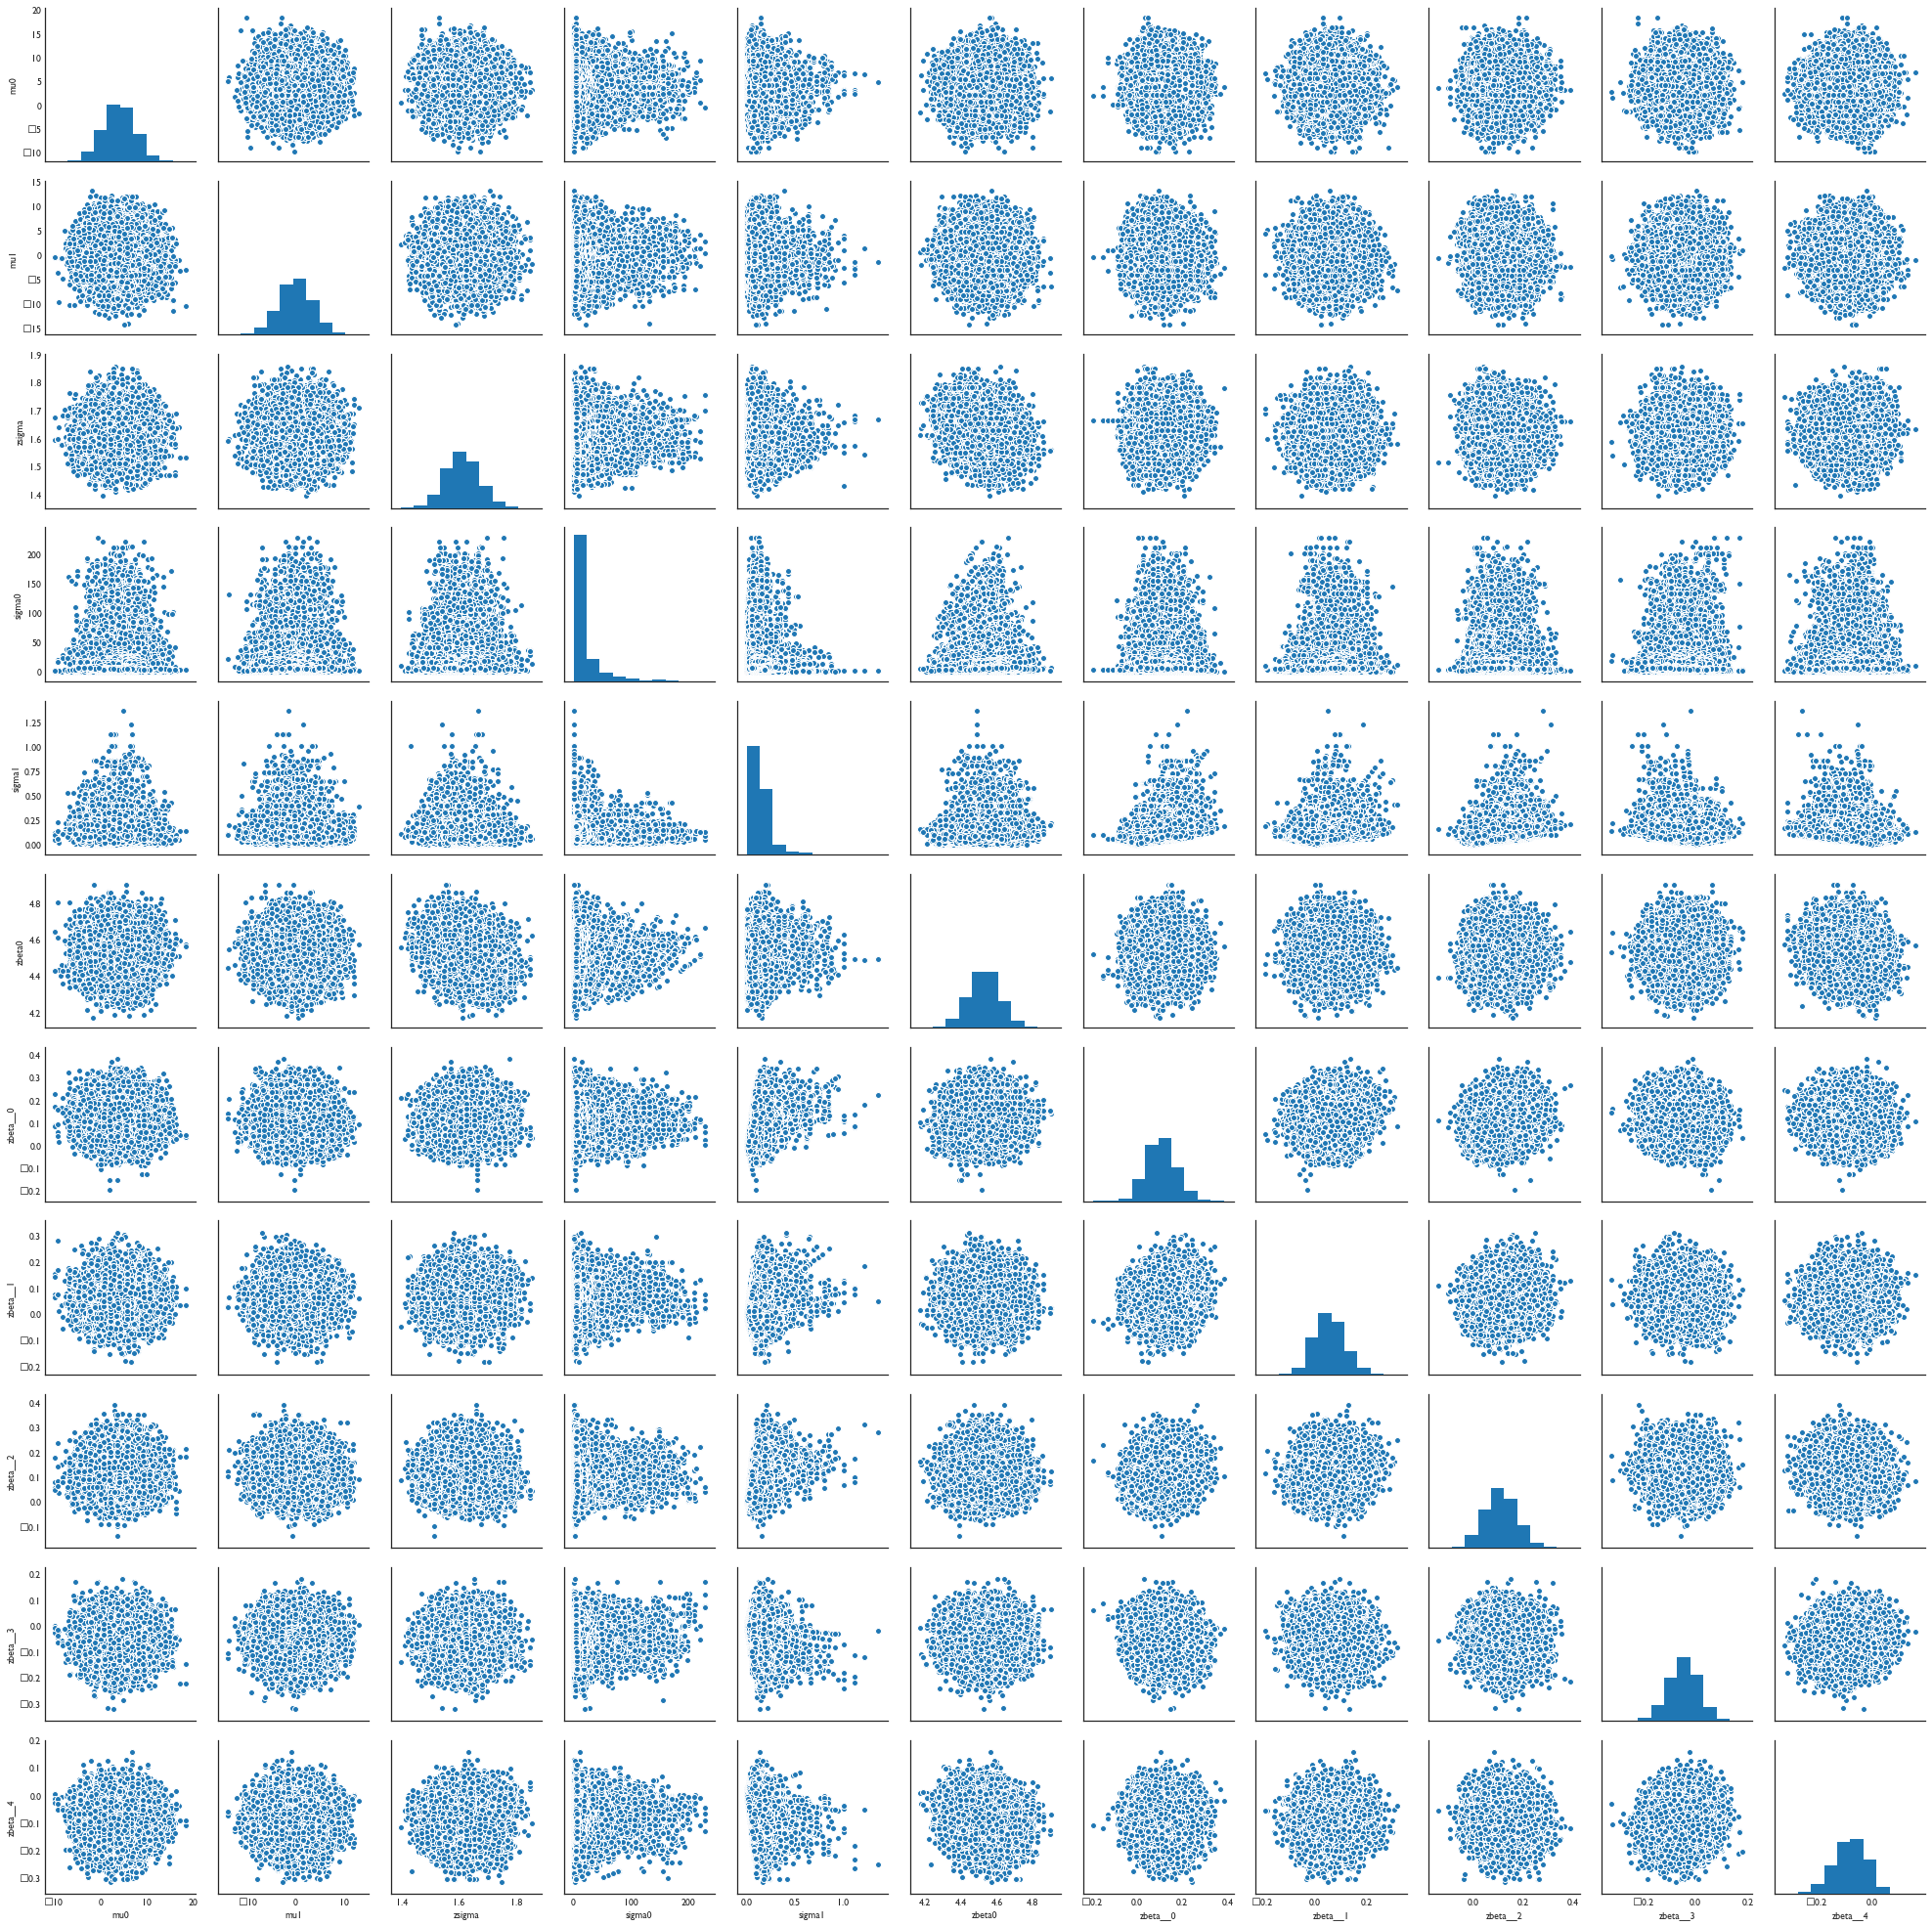

In [21]:
tracedf1 = pm.trace_to_dataframe(trace4, varnames=['mu0', 'mu1', 'zsigma', 'sigma0', 'sigma1','zbeta0', 'zbeta'])
g = sb.pairplot(tracedf1);

In [16]:
g.savefig("pair plot main experiment, non-centered, hierarchical.pdf")

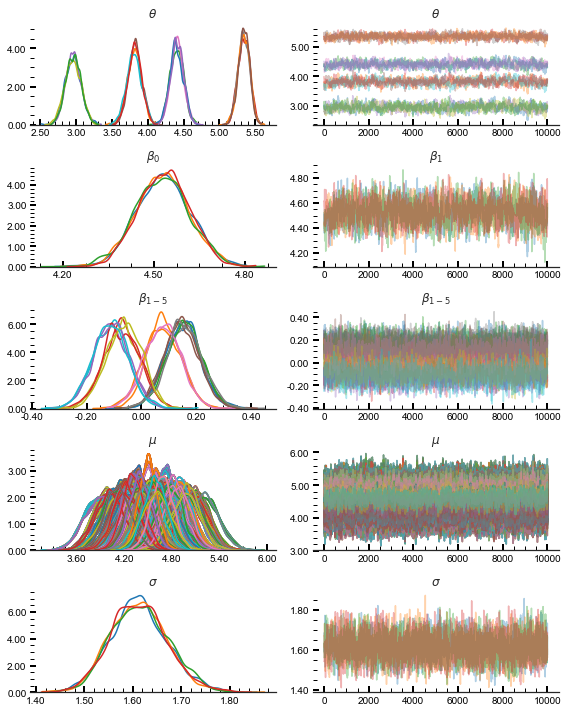

In [45]:
burned_trace = trace4 # pymc3.1 discards the first 500 samples
# pm.traceplot(burned_trace);

NRows = 5  # change based on the number of parameters
NCols = 2
sb.set_style("white")
fig, axs = sb.mpl.pyplot.subplots(NRows,
                                  NCols)  #### change on changing parameters
fig.set_size_inches(8, 10)
# fig, axs = sb.plt.subplots(5, 2) #### change on changing parameters
# fig.set_size_inches(12, 12)
pm.plots.traceplot(
    trace=burned_trace,
        varnames=['theta_missing', 'zbeta0', 'zbeta', 'mu', 'zsigma'],
    ax=axs)
axs[0, 0].set_title(r"$\theta$")
axs[0, 1].set_title(r"$\theta$")
axs[1, 0].set_title(r"$\beta_0$")
axs[1, 1].set_title(r"$\beta_1$")
axs[2, 0].set_title(r"$\beta_{1-5}$")
axs[2, 1].set_title(r"$\beta_{1-5}$")
axs[3, 0].set_title(r"$\mu$")
axs[3, 1].set_title(r"$\mu$")
axs[4, 0].set_title(r"$\sigma$")
axs[4, 1].set_title(r"$\sigma$")
axs[1, 0].xaxis.set_major_locator(plt.MaxNLocator(3))
axs[3, 0].xaxis.set_major_locator(plt.MaxNLocator(6))
axs[4, 0].xaxis.set_major_locator(plt.MaxNLocator(6))
for i in range(NRows):
    for j in range(NCols):
        z = axs[i, j]
        z.set_xlabel("")  # no individual labels
        z.set_ylabel("")
        if j==0:
            z.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        else:
            z.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        z.tick_params(
            direction='in', length=6, width=2, colors='k', which='major')
        z.tick_params(
            direction='in', length=4, width=1, colors='k', which='minor')
        z.xaxis.set_ticks_position('bottom')
        z.yaxis.set_ticks_position('left')
        z.minorticks_on()
        
sb.despine(fig=fig, left=True)
fig.tight_layout()
fig.savefig("traceplots, main, Cauchy.pdf")

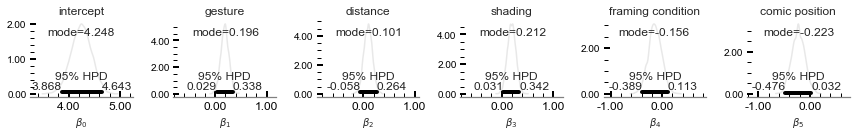

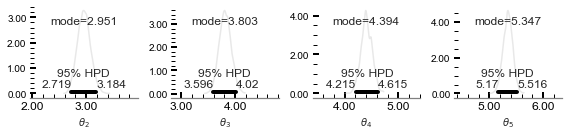

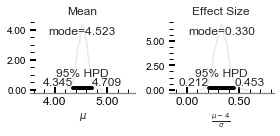

In [23]:
burnin = 500
# Convert parameters to original scale
beta = trace4['zbeta'] / sd_X.as_matrix()
beta0 = trace4['zbeta0'] - np.sum(
    trace4['zbeta'] * mean_X.as_matrix() / sd_X.as_matrix(), axis=1)
sigma = trace4['zsigma']

sigma = trace4['zsigma']
mu = trace4['mu']
mu_mean = np.mean(mu, axis=1)

# compute the effect size
center = 4
n_m = (mu_mean - center) / sigma

NRows = 1  # change based on the number of parameters
NCols = 6
sb.set_style("white")
fig, axs = sb.mpl.pyplot.subplots(NRows,
                                  NCols)  #### change on changing parameters
fig.set_size_inches(NCols * 2, 2)

# Plot posteriors
pm.plot_posterior(
    beta0,
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    ax=axs[0],
    text_size=12)
pm.plot_posterior(
    beta[:, 0],
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    ax=axs[1],
    text_size=12)
pm.plot_posterior(
    beta[:, 1],
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    ax=axs[2],
    text_size=12)
pm.plot_posterior(
    beta[:, 2],
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    ax=axs[3],
    text_size=12)
pm.plot_posterior(
    beta[:, 3],
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    ax=axs[4],
    text_size=12)
pm.plot_posterior(
    beta[:, 4],
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    ax=axs[5],
    text_size=12)

beta_vars = [
    'intercept', 'gesture', 'distance', 'shading', 'framing condition',
    'comic position'
]
for j in range(NCols):
    z = axs[j]
    #     z.set_xlabel("") # no individual labels
    #     z.set_ylabel("")
    s = "$\\beta_{{{0}}}$".format(j)
    z.set_xlabel(s)
    z.set_title("{0}".format(beta_vars[j]))
    if j==0:
        center = beta0.mean()
    else:
        center = beta[:,j-1].mean()
    z.set_xlim([center-1, center+1])  
    
    z.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
    z.tick_params(direction='in', length=4, width=1, colors='k', which='minor')
    z.xaxis.set_ticks_position('bottom')
    z.yaxis.set_ticks_position('left')
    z.minorticks_on()

fig.tight_layout()

fig.savefig("beta_values_main, cauchy.pdf")


# plot theta posterior

NRows = 1  # change based on the number of parameters
NCols = 4  # four interior values
sb.set_style("white")
fig3, axs3 = sb.mpl.pyplot.subplots(NRows,
                                    NCols)  #### change on changing parameters
fig3.set_size_inches(NCols * 2, 2)

# Plot posteriors
pm.plot_posterior(
    trace4['theta_missing'][:, 0],
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    ax=axs3[0],
    text_size=12)
pm.plot_posterior(
    trace4['theta_missing'][:, 1],
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    ax=axs3[1],
    text_size=12)
pm.plot_posterior(
    trace4['theta_missing'][:, 2],
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    ax=axs3[2],
    text_size=12)
pm.plot_posterior(
    trace4['theta_missing'][:, 3],
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    ax=axs3[3],
    text_size=12)

# beta_vars = ['intercept', 'color', 'location', 'condition']
for j in range(NCols):
    z = axs3[j]
    #     z.set_xlabel("") # no individual labels
    #     z.set_ylabel("")
    s = "$\\theta_{{{0}}}$".format(j+2)
    z.set_xlabel("{0}".format(s))
    center = trace4['theta_missing'][:, j].mean()
    z.set_xlim([center-1, center+1])

    z.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
    z.tick_params(direction='in', length=4, width=1, colors='k', which='minor')
    z.xaxis.set_ticks_position('bottom')
    z.yaxis.set_ticks_position('left')
    z.minorticks_on()

fig3.tight_layout()

fig3.savefig("theta_values_main, cauchy.pdf")



fig2, axs2 = sb.mpl.pyplot.subplots(1, 2)  #### change on changing parameters
fig2.set_size_inches(4, 2)

pm.plot_posterior(
    mu_mean,
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    ax=axs2[0],
    text_size=12)
pm.plot_posterior(
    n_m,
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    ax=axs2[1],
    text_size=12)

axs2[0].set_title(r'Mean')
axs2[0].set_xlim([mu_mean.mean()-1,mu_mean.mean()+1])
axs2[0].set_xlabel(r'$\mu$')

axs2[1].set_title(r"Effect Size")
axs2[1].set_xlim([n_m.mean()-0.5, n_m.mean()+0.5])
axs2[1].set_xlabel(r'$\frac{\mu -4}{\sigma}$')

axs2[0].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs2[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs2[0].tick_params(direction='in', length=6, width=2, colors='k', which='major')
axs2[0].tick_params(direction='in', length=4, width=1, colors='k', which='minor')
axs2[0].xaxis.set_ticks_position('bottom')
axs2[0].yaxis.set_ticks_position('left')
axs2[0].minorticks_on()

axs2[1].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs2[1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs2[1].tick_params(direction='in', length=6, width=2, colors='k', which='major')
axs2[1].tick_params(direction='in', length=4, width=1, colors='k', which='minor')
axs2[1].xaxis.set_ticks_position('bottom')
axs2[1].yaxis.set_ticks_position('left')
axs2[1].minorticks_on()

fig2.tight_layout()
fig2.savefig("mean_effect, posterior, main experiment, cauchy.pdf")

# for title, label, ax in zip(['Intercept', 'Year', 'Length'],
#                             [r'$\beta_{0}$', r'$\beta_{1}$', r'$\beta_{2}$'],
#                             [ax2, ax3, ax4]):
#     ax.set_title(title, fontdict=f_dict)
#     ax.set_xlabel(label, fontdict=f_dict)

# Color v. No Color

## data

In [32]:
# Using dtype 'category' for Y
df_color = pd.read_csv(
    'data/color_data_0330.csv',
    dtype={
        'y': 'int',
        'color': 'int',
        'color_position': 'int',
        'cond': 'int'
    })

In [33]:
df_color.columns = ['color', 'location', 'condition', 'y']

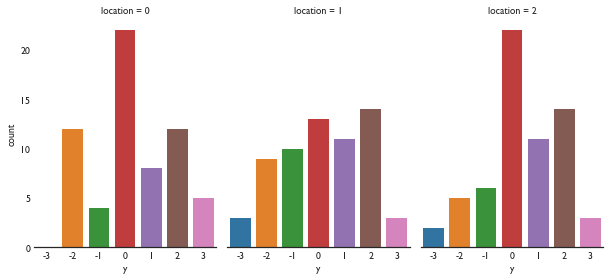

In [34]:
g_color = sb.factorplot(
    x="y",
#     hue="condition",
    col="location",
#     row="location",
    data=df_color,
    kind="count",
    size=4,
    aspect=0.7)
g_color.despine(left=True)
g_color.savefig("effects_of_color.pdf")

## Bayesian analysis of color

In [35]:
X = df_color[['color', 'location', 'condition']]

# defining some temp variables for the least squares estimate.
X_i = (X - X.mean())/X.std() # predictors
Y_r = (df_color['y'] + 4).values # to create a response variable
X_i['c'] = 1
X_i = X_i.reindex(columns=['c', 'color', 'location', 'condition'])

df_color['y'] = (df_color['y'] + 4).astype(
    'category')  # changing the range to 1-7
y_cat = (df_color['y']).astype('category')  # in range 1-7
nYlevels = y_cat.nunique()

In [38]:
[beta_test_val, residual, rank, eig] = np.linalg.lstsq(X_i, Y_r, rcond=None)

In [43]:
beta_test_val[[1,2,3]]

array([0.20993612, 0.05908573, 0.16207064])

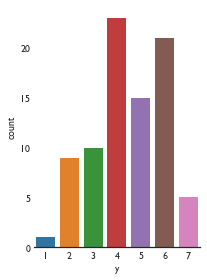

In [40]:
Pos = df_color[df_color.condition==1]
g_color = sb.factorplot(
    x="y",
    data=Pos,
    kind="count",
    size=4,
    aspect=0.7)
g_color.despine(left=True)

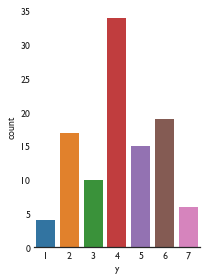

In [41]:
Neg = df_color[df_color.condition==0]
g_color = sb.factorplot(
    x="y",
    data=Neg,
    kind="count",
    size=4,
    aspect=0.7)
g_color.despine(left=True)

In [40]:
sd_X = X.std()
mean_X = X.mean()
zX = (X - mean_X)/sd_X

In [41]:
nYlevels4 = y_cat.nunique()

thresh4 = [k + 0.5
           for k in range(1, nYlevels4)]  # fixing the boundaries in our case
thresh_obs4 = np.ma.asarray(thresh4)
thresh_obs4[1:-1] = np.ma.masked

print('thresh4:\t{}'.format(thresh4))
print('thresh_obs4:\t{}'.format(thresh_obs4))

#initial probabilities
pr_test_val = df_color.groupby('y').size()/df_color.shape[0]

thresh4:	[1.5, 2.5, 3.5, 4.5, 5.5, 6.5]
thresh_obs4:	[1.5 -- -- -- -- 6.5]


In [44]:
@as_op(itypes=[tt.dvector, tt.dvector, tt.dscalar], otypes=[tt.dmatrix])
def outcome_probabilities(theta, mu, sigma):
    out = np.empty((mu.size, nYlevels4))
    n = norm(loc=mu, scale=sigma)
    out[:, 0] = n.cdf(theta[0])
    out[:, 1] = np.max(
        [np.repeat(0, mu.size),
         n.cdf(theta[1]) - n.cdf(theta[0])], axis=0)
    out[:, 2] = np.max(
        [np.repeat(0, mu.size),
         n.cdf(theta[2]) - n.cdf(theta[1])], axis=0)
    out[:, 3] = np.max(
        [np.repeat(0, mu.size),
         n.cdf(theta[3]) - n.cdf(theta[2])], axis=0)
    out[:, 4] = np.max(
        [np.repeat(0, mu.size),
         n.cdf(theta[4]) - n.cdf(theta[3])], axis=0)
    out[:, 5] = np.max(
        [np.repeat(0, mu.size),
         n.cdf(theta[5]) - n.cdf(theta[4])], axis=0)
    out[:, 6] = 1 - n.cdf(theta[5])
    return out


with pm.Model() as ordinal_model_color:

    theta = pm.Normal(
        'theta',
        mu=thresh4,
        tau=np.repeat(1 / 2**2, len(thresh4)),
        shape=len(thresh4),
        observed=thresh_obs4,
        testval=thresh4)

    # all coefficients should center at 0.0 because outocme 'y' is symmetric [-3,3]
    zbeta0 = pm.Normal('zbeta0', mu=(1 + nYlevels4) / 2, tau=1 / nYlevels4**2, testval=beta_test_val[0])
    zbeta = pm.Normal('zbeta', mu=0.0, tau=1 / nYlevels4**2, shape=X.shape[1], testval=beta_test_val[[1, 2, 3]])
    mu = pm.Deterministic('mu', zbeta0 + pm.math.dot(zbeta, zX.T))
    zsigma = pm.Uniform('zsigma', nYlevels4 / 1000.0, nYlevels4, testval=1.5)

    pr = outcome_probabilities(theta, mu, zsigma)

    y = pm.Categorical('Y_obs', pr, observed=y_cat.cat.codes, testval=pr_test_val)

In [46]:
with ordinal_model_color:
    step1 = pm.Metropolis()
    trace4 = pm.sample(10000, step=step1)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [zsigma_interval__]
>Metropolis: [zbeta]
>Metropolis: [zbeta0]
>Metropolis: [theta_missing]
100%|██████████| 10500/10500 [07:00<00:00, 24.95it/s]
The number of effective samples is smaller than 10% for some parameters.


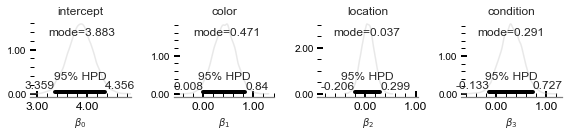

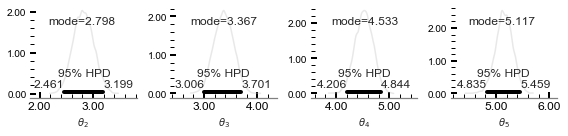

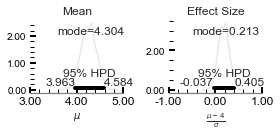

In [88]:
# Convert parameters to original scale
beta = trace4['zbeta'] / sd_X.as_matrix()
beta0 = trace4['zbeta0'] - np.sum(
    trace4['zbeta'] * mean_X.as_matrix() / sd_X.as_matrix(), axis=1)

sigma = trace4['zsigma']
mu = trace4['mu']
mu_mean = np.mean(mu, axis=1)

# compute the effect size
center = 4
n_m = (mu_mean - center) / sigma

NRows = 1  # change based on the number of parameters
NCols = X.shape[1] + 1  # adding 1 for \beta_0
sb.set_style("white")
fig, axs = sb.mpl.pyplot.subplots(NRows,
                                  NCols)  #### change on changing parameters
fig.set_size_inches(NCols * 2, 2)

# Plot posteriors
pm.plot_posterior(
    beta0,
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    ax=axs[0],
    text_size=12)
pm.plot_posterior(
    beta[:, 0],
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    ax=axs[1],
    text_size=12)
pm.plot_posterior(
    beta[:, 1],
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    ax=axs[2],
    text_size=12)
pm.plot_posterior(
    beta[:, 2],
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    ax=axs[3],
    text_size=12)

beta_vars = ['intercept', 'color', 'location', 'condition']
for j in range(NCols):
    z = axs[j]
    #     z.set_xlabel("") # no individual labels
    #     z.set_ylabel("")
    s = "$\\beta_{{{0}}}$".format(j)
    z.set_xlabel(s)
    z.set_title("{0}".format(beta_vars[j]))
    if j==0:
        center = beta0.mean()
    else:
        center = beta[:,j-1].mean()
    z.set_xlim([center-1, center+1])    
    z.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
    z.tick_params(direction='in', length=4, width=1, colors='k', which='minor')
    z.xaxis.set_ticks_position('bottom')
    z.yaxis.set_ticks_position('left')
    z.minorticks_on()

fig.tight_layout()

fig.savefig("beta_values_color.pdf")

# plot theta posterior

NRows = 1  # change based on the number of parameters
NCols = 4  # four interior values
sb.set_style("white")
fig3, axs3 = sb.mpl.pyplot.subplots(NRows,
                                    NCols)  #### change on changing parameters
fig3.set_size_inches(NCols * 2, 2)

# Plot posteriors
pm.plot_posterior(
    trace4['theta_missing'][:, 0],
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    ax=axs3[0],
    text_size=12)
pm.plot_posterior(
    trace4['theta_missing'][:, 1],
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    ax=axs3[1],
    text_size=12)
pm.plot_posterior(
    trace4['theta_missing'][:, 2],
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    ax=axs3[2],
    text_size=12)
pm.plot_posterior(
    trace4['theta_missing'][:, 3],
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    ax=axs3[3],
    text_size=12)

# beta_vars = ['intercept', 'color', 'location', 'condition']
for j in range(NCols):
    z = axs3[j]
    #     z.set_xlabel("") # no individual labels
    #     z.set_ylabel("")
    s = "$\\theta_{{{0}}}$".format(j+2)
    z.set_xlabel("{0}".format(s))
    center = trace4['theta_missing'][:, j].mean()
    z.set_xlim([center-1, center+1])

    z.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
    z.tick_params(direction='in', length=4, width=1, colors='k', which='minor')
    z.xaxis.set_ticks_position('bottom')
    z.yaxis.set_ticks_position('left')
    z.minorticks_on()

fig3.tight_layout()

fig3.savefig("theta_values_color.pdf")

# mean and mean effect size

fig2, axs2 = sb.mpl.pyplot.subplots(1, 2)  #### change on changing parameters
fig2.set_size_inches(4, 2)

pm.plot_posterior(
    mu_mean,
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    ax=axs2[0],
    text_size=12)
pm.plot_posterior(
    n_m,
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    ax=axs2[1],
    text_size=12)

axs2[0].set_title(r"Mean")
axs2[0].set_xlim([3, 5])
axs2[0].set_xlabel(r'$\mu$')

axs2[1].set_title(r"Effect Size")
axs2[1].set_xlim([-1, 1])
axs2[1].set_xlabel(r'$\frac{\mu-4}{\sigma}$')

axs2[0].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs2[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs2[0].tick_params(
    direction='in', length=6, width=2, colors='k', which='major')
axs2[0].tick_params(
    direction='in', length=4, width=1, colors='k', which='minor')
axs2[0].xaxis.set_ticks_position('bottom')
axs2[0].yaxis.set_ticks_position('left')
axs2[0].minorticks_on()

axs2[1].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs2[1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs2[1].tick_params(
    direction='in', length=6, width=2, colors='k', which='major')
axs2[1].tick_params(
    direction='in', length=4, width=1, colors='k', which='minor')
axs2[1].xaxis.set_ticks_position('bottom')
axs2[1].yaxis.set_ticks_position('left')
axs2[1].minorticks_on()

fig2.tight_layout()
fig2.savefig("mean_effect_color.pdf")

# for title, label, ax in zip(['Intercept', 'Year', 'Length'],
#                             [r'$\beta_{0}$', r'$\beta_{1}$', r'$\beta_{2}$'],
#                             [ax2, ax3, ax4]):
#     ax.set_title(title, fontdict=f_dict)
#     ax.set_xlabel(label, fontdict=f_dict)

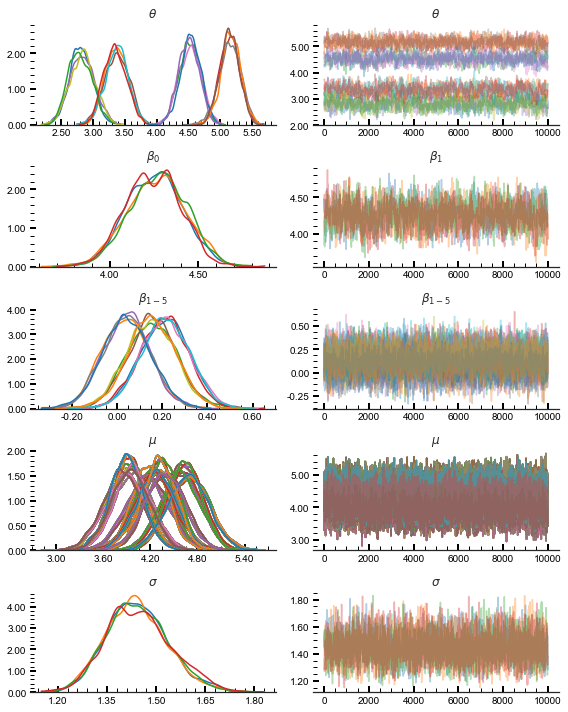

In [48]:
burned_trace = trace4 # pymc3.1 discards the first 500 samples
# pm.traceplot(burned_trace);

NRows = 5  # change based on the number of parameters
NCols = 2
sb.set_style("white")
fig, axs = sb.mpl.pyplot.subplots(NRows,
                                  NCols)  #### change on changing parameters
fig.set_size_inches(8, 10)
# fig, axs = sb.plt.subplots(5, 2) #### change on changing parameters
# fig.set_size_inches(12, 12)
pm.plots.traceplot(
    trace=burned_trace,
    #     varnames=['theta_missing', 'zbeta0', 'zbeta', 'mu', 'zsigma'],
    #     lines={
    #         'b0': (burned_trace['b0']).mean(),
    #         'b1': (burned_trace['b1']).mean(),
    #         'b2': (burned_trace['b2']).mean(),
    #         'b3': (burned_trace['b3']).mean(),
    #         'b4': (burned_trace['b4']).mean(),
    #     }
    ax=axs)
axs[0, 0].set_title(r"$\theta$")
axs[0, 1].set_title(r"$\theta$")
axs[1, 0].set_title(r"$\beta_0$")
axs[1, 1].set_title(r"$\beta_1$")
axs[2, 0].set_title(r"$\beta_{1-5}$")
axs[2, 1].set_title(r"$\beta_{1-5}$")
axs[3, 0].set_title(r"$\mu$")
axs[3, 1].set_title(r"$\mu$")
axs[4, 0].set_title(r"$\sigma$")
axs[4, 1].set_title(r"$\sigma$")
axs[1, 0].xaxis.set_major_locator(plt.MaxNLocator(3))
axs[3, 0].xaxis.set_major_locator(plt.MaxNLocator(6))
axs[4, 0].xaxis.set_major_locator(plt.MaxNLocator(6))
for i in range(NRows):
    for j in range(NCols):
        z = axs[i, j]
        z.set_xlabel("")  # no individual labels
        z.set_ylabel("")
        if j==0:
            z.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        else:
            z.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        z.tick_params(
            direction='in', length=6, width=2, colors='k', which='major')
        z.tick_params(
            direction='in', length=4, width=1, colors='k', which='minor')
        z.xaxis.set_ticks_position('bottom')
        z.yaxis.set_ticks_position('left')
        z.minorticks_on()
        
sb.despine(fig=fig, left=True)
fig.tight_layout()
fig.savefig("posterior plots, color, not pooled.pdf")

In [49]:
pm.summary(trace4)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta_missing__0,2.821078,0.189145,0.008089,2.461268,3.198816,482.0,1.003095
theta_missing__1,3.366133,0.181527,0.007785,3.005687,3.700985,465.0,1.003345
theta_missing__2,4.520100,0.165763,0.006827,4.206344,4.843725,524.0,1.002686
theta_missing__3,5.152939,0.159192,0.006098,4.834503,5.459481,629.0,1.002004
zbeta0,4.256721,0.160774,0.005723,3.963445,4.583631,680.0,1.003184
zbeta__0,0.208920,0.107656,0.001935,0.004251,0.421229,3544.0,1.000488
zbeta__1,0.040457,0.105455,0.001591,-0.168688,0.244608,3848.0,1.000308
zbeta__2,0.151107,0.109593,0.001849,-0.066324,0.362434,3232.0,1.000234
mu__0,4.585269,0.253262,0.006368,4.089879,5.073903,1398.0,1.000959
mu__1,4.585269,0.253262,0.006368,4.089879,5.073903,1398.0,1.000959


In [91]:
axs.shape

(2,)

# Hierarchical regression on Individuals within groups (Effect of Color)

In [18]:
# Using dtype 'category' for Y
df_color_H = pd.read_csv(
    'data/color_data_0330_ID.csv',
    dtype={
        'ID': 'int',
        'y': 'int',
        'color': 'int',
        'color_position': 'int',
        'cond': 'int'
    })


df_color_H.columns = ['Subj', 'color', 'location', 'condition', 'y']
X = df_color_H[['color', 'location', 'condition']]

# defining some temp variables for the least squares estimate.
X_i = (X - X.mean())/X.std() # predictors
Y_r = (df_color_H['y'] + 4).values # to create a response variable
X_i['c'] = 1
X_i = X_i.reindex(columns=['c', 'color', 'location', 'condition'])
[beta_test_val, residual, rank, eig] = np.linalg.lstsq(X_i, Y_r, rcond=None)
print("beta test values: {}".format(beta_test_val.round(3)))



df_color_H['y'] = df_color_H['y'] + 4
y_cat = (df_color_H['y']).astype('category')  # in range 1-7
nYlevels = y_cat.nunique()

df_color_H.Subj = df_color_H.Subj.astype('category')
df_color_H.Subj = df_color_H.Subj.cat.as_ordered()
df_color_H.info()

beta test values: [4.296 0.21  0.059 0.162]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189 entries, 0 to 188
Data columns (total 5 columns):
Subj         189 non-null category
color        189 non-null int64
location     189 non-null int64
condition    189 non-null int64
y            189 non-null int64
dtypes: category(1), int64(4)
memory usage: 9.2 KB


In [16]:
beta_test_val.round(3)

array([4.296, 0.21 , 0.059, 0.162])

### getting the number of individuals

In [3]:
subj_idx = df_color_H.Subj.cat.codes.as_matrix() #forms the index
subj_codes = df_color_H.Subj.cat.categories
n_subj = len(subj_codes)

print('Number of groups: {}'.format(n_subj))

Number of groups: 63


In [29]:
df_color_H.Subj.cat.codes[df_color_H.Subj.cat.codes==2]

2     2
30    2
58    2
dtype: int8

In [37]:
df_color_H.Subj.cat.codes

0       0
1       1
2       2
3       3
4       4
5       5
6       6
7       7
8       8
9       9
10     10
11     11
12     12
13     13
14     14
15     15
16     16
17     17
18     18
19     19
20     20
21     21
22     22
23     23
24     24
25     25
26     26
27     27
28      0
29      1
       ..
159    33
160    34
161    35
162    36
163    37
164    38
165    39
166    40
167    41
168    42
169    43
170    44
171    45
172    46
173    47
174    48
175    49
176    50
177    51
178    52
179    53
180    54
181    55
182    56
183    57
184    58
185    59
186    60
187    61
188    62
Length: 189, dtype: int8

In [42]:
a = np.arange(0,100)
b = a[df_color_H.Subj.cat.codes.as_matrix()]
df_color_H.Subj.cat.codes.as_matrix()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,  0,  1,  2,  3,  4,  5,
        6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
       23, 24, 25, 26, 27,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,
       12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
       29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
       46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62,
       28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
       45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61,
       62, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62], dtype=int8)

In [19]:
pr_test_val = df_color_H.groupby('y').size()/df_color_H.shape[0]
print("Category Probabilities: {}".format(pr_test_val.round(3)))

Category Probabilities: y
1    0.026
2    0.138
3    0.106
4    0.302
5    0.159
6    0.212
7    0.058
dtype: float64


### normalization

In [20]:
# predictors
sd_color = df_color_H.color.std()
mean_color = df_color_H.color.mean()
zcolor = (df_color_H.color - mean_color)/sd_color

sd_location = df_color_H.location.std()
mean_location = df_color_H.location.mean()
zlocation = (df_color_H.location - mean_location)/sd_location

sd_condition = df_color_H.condition.std()
mean_condition = df_color_H.condition.mean()
zcondition = (df_color_H.condition - mean_condition)/sd_condition


# response
sd_y = df_color_H.y.std()
mean_y = df_color_H.y.mean()
zy = (df_color_H.y - mean_y)/sd_y

# number of levels

nYlevels4 = y_cat.nunique()

thresh = [k + 0.5
           for k in range(1, nYlevels4)]  # fixing the boundaries in our case
thresh_obs = np.ma.asarray(thresh)
thresh_obs[1:-1] = np.ma.masked

print('thresh:\t{}'.format(thresh))
print('thresh_obs:\t{}'.format(thresh_obs))


# initial probabilities 
pr_test_val = df_color_H.groupby('y').size()/df_color_H.shape[0]

thresh:	[1.5, 2.5, 3.5, 4.5, 5.5, 6.5]
thresh_obs:	[1.5 -- -- -- -- 6.5]


In [21]:
nYlevels4

7

### Model

$$\mu_{i,j} = \beta_{0,j} + \sum_{k=1}^3 \beta_{k,j} x_{k, j} $$

In [49]:
# helps compute the cdf


@as_op(itypes=[tt.dvector, tt.dvector, tt.dscalar], otypes=[tt.dmatrix])
def outcome_probabilities(theta, mu, sigma):

    out = np.empty((mu.size, nYlevels4))
    n = norm(loc=mu, scale=sigma)
    out[:, 0] = n.cdf(theta[0])
    out[:, 1] = np.max(
        [np.repeat(0, mu.size),
         n.cdf(theta[1]) - n.cdf(theta[0])], axis=0)
    out[:, 2] = np.max(
        [np.repeat(0, mu.size),
         n.cdf(theta[2]) - n.cdf(theta[1])], axis=0)
    out[:, 3] = np.max(
        [np.repeat(0, mu.size),
         n.cdf(theta[3]) - n.cdf(theta[2])], axis=0)
    out[:, 4] = np.max(
        [np.repeat(0, mu.size),
         n.cdf(theta[4]) - n.cdf(theta[3])], axis=0)
    out[:, 5] = np.max(
        [np.repeat(0, mu.size),
         n.cdf(theta[5]) - n.cdf(theta[4])], axis=0)
    out[:, 6] = 1 - n.cdf(theta[5])
    return out


with pm.Model() as h_ordinal_model:

    # common thresholds for the metric space model
    # that is, everyone shares the thresholds

    theta = pm.Normal(
        'theta',
        mu=thresh,
        tau=np.repeat(1 / 2**2, len(thresh)),
        shape=len(thresh),
        observed=thresh_obs,
        testval=thresh)

    # priors on the means of the normal prior for \beta
    mu0 = pm.Normal('mu0', 0, tau=1 / nYlevels4**2)
    sigma0 = pm.HalfCauchy('sigma0', beta=nYlevels4**2)

    #     mu1 = pm.Normal('mu1', mu=0, tau=1 / nYlevels4**2)
    #     mu2 = pm.Normal('mu2', mu=0, tau=1 / nYlevels4**2)
    #     mu3 = pm.Normal('mu3', mu=0, tau=1 / nYlevels4**2)

    # priors on the standard deviation of the normal prior for \beta

    #     sigma1 = pm.HalfCauchy('sigma1', beta=nYlevels4**2)
    #     sigma2 = pm.Uniform('sigma2', 10**-3, nYlevels4**2)
    #     sigma3 = pm.Uniform('sigma3', 10**-3, nYlevels4**2)

    # creating a beta per subject

    #     beta0_s = pm.Cauchy('beta0_s', alpha=(1 + nYlevels4) / 2, beta=nYlevels4**2, shape=n_subj, testval=beta_test_val[0])
    #     beta1_s = pm.Cauchy('beta1_s', alpha=0.0, beta=nYlevels4**2, shape=n_subj, testval=beta_test_val[1])
    #     beta2_s = pm.Cauchy('beta2_s', alpha=0.0, beta=nYlevels4**2, shape=n_subj, testval=beta_test_val[2])
    #     beta3_s = pm.Cauchy('beta3_s', alpha=0.0, beta=nYlevels4**2, shape=n_subj, testval=beta_test_val[3])

#     beta0_s = pm.Deterministic('beta0_s', (1 + nYlevels4) / 2 + pm.Normal(
#         'z0', mu=mu0, sd=sigma0, shape=n_subj, testval=0))

    
                               
    z0 = pm.Normal('z0s', mu=0, sd=1, shape=n_subj, testval=0)
    z1 = pm.Normal('z1s', mu=0, sd=1, shape=n_subj, testval=0)
    z2 = pm.Normal('z2s', mu=0, sd=1, shape=n_subj, testval=0)
    z3 = pm.Normal('z3s', mu=0, sd=1, shape=n_subj, testval=0)
    
    
    beta0_s = pm.Deterministic('beta0_s', (1 + nYlevels4) / 2 + mu0 + z0*sigma0)
    beta1_s = pm.Deterministic('beta1_s',  mu0 + z1*sigma0)
    beta2_s = pm.Deterministic('beta2_s',  mu0 + z2*sigma0)
    beta3_s = pm.Deterministic('beta3_s',  mu0 + z3*sigma0)
    
#     beta1_s = pm.Normal(
#         'beta1_s', mu=mu0, sd=sigma0, shape=n_subj, testval=beta_test_val[1])
#     beta2_s = pm.Normal(
#         'beta2_s', mu=mu0, sd=sigma0, shape=n_subj, testval=beta_test_val[2])
#     beta3_s = pm.Normal(
#         'beta3_s', mu=mu0, sd=sigma0, shape=n_subj, testval=beta_test_val[3])

    # computing the probability of observing the data
    # zsigma is the standard deviation of the underlying normal distribution

    mu = pm.Deterministic(
        'mu', beta0_s[subj_idx] + beta1_s[subj_idx] * zcolor +
        beta2_s[subj_idx] * zlocation + beta3_s[subj_idx] * zcondition)

    zsigma = pm.HalfCauchy('zsigma', beta=nYlevels4 * 10.0, testval=1.5)
    #     zsigma = pm.HalfCauchy('zsigma', beta=nYlevels4, testval=1.5)
    pr = outcome_probabilities(theta, mu, zsigma)

    y = pm.Categorical(
        'Y_obs', pr, observed=y_cat.cat.codes, testval=pr_test_val)

In [45]:
with h_ordinal_model:
    step1 = pm.Metropolis()
    h_color_trace = pm.sample(10000, step=step1)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [zsigma_interval__]
>Metropolis: [beta3_s]
>Metropolis: [beta2_s]
>Metropolis: [beta1_s]
>Metropolis: [z0]
>Metropolis: [sigma0_log__]
>Metropolis: [mu0]
>Metropolis: [theta_missing]
100%|██████████| 10500/10500 [09:27<00:00, 18.51it/s]
The gelman-rubin statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


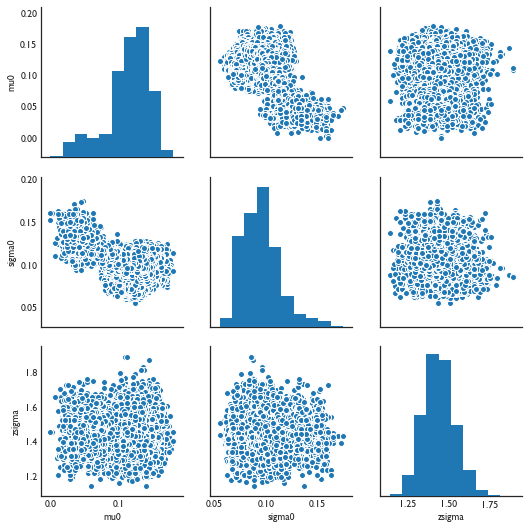

In [48]:
tracedf1 = pm.trace_to_dataframe(h_color_trace, varnames=['mu0',  'sigma0', 'zsigma'])
g = sb.pairplot(tracedf1);

### pooled plots

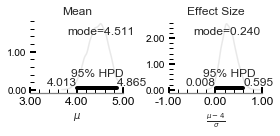

In [28]:

sigma = h_color_trace['zsigma']
mu = h_color_trace['mu']
mu_mean = np.mean(mu, axis=1)

# compute the effect size
center = 4
n_m = (mu_mean - center) / sigma

fig2, axs2 = sb.mpl.pyplot.subplots(1, 2)  #### change on changing parameters
fig2.set_size_inches(4, 2)

pm.plot_posterior(
    mu_mean,
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    ax=axs2[0],
    text_size=12)
pm.plot_posterior(
    n_m,
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    ax=axs2[1],
    text_size=12)

axs2[0].set_title(r"Mean")
axs2[0].set_xlim([3,5])
axs2[0].set_xlabel(r'$\mu$')

axs2[1].set_title(r"Effect Size")
axs2[1].set_xlim([-1,1])
axs2[1].set_xlabel(r'$\frac{\mu-4}{\sigma}$')

axs2[0].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs2[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs2[0].tick_params(direction='in', length=6, width=2, colors='k', which='major')
axs2[0].tick_params(direction='in', length=4, width=1, colors='k', which='minor')
axs2[0].xaxis.set_ticks_position('bottom')
axs2[0].yaxis.set_ticks_position('left')
axs2[0].minorticks_on()

axs2[1].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs2[1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs2[1].tick_params(direction='in', length=6, width=2, colors='k', which='major')
axs2[1].tick_params(direction='in', length=4, width=1, colors='k', which='minor')
axs2[1].xaxis.set_ticks_position('bottom')
axs2[1].yaxis.set_ticks_position('left')
axs2[1].minorticks_on()

fig2.tight_layout()
fig2.savefig("mean_effect_color_pooled.pdf")

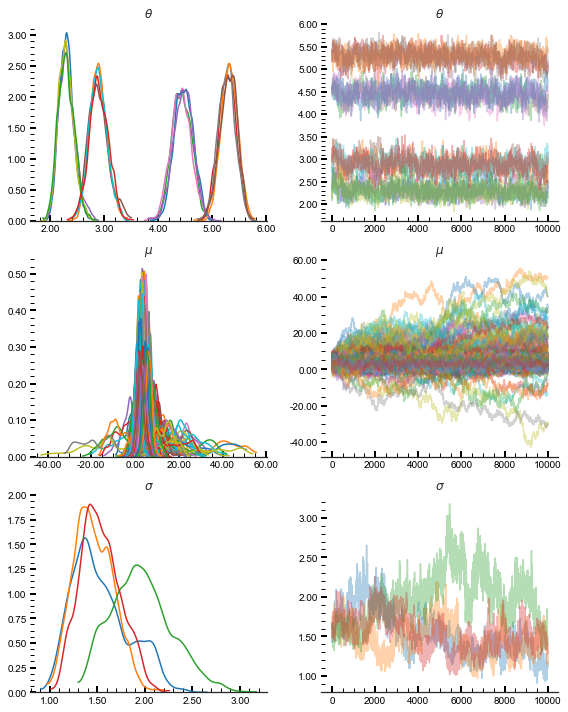

In [27]:
burned_trace = h_color_trace # pymc3.1 discards the first 500 samples
# pm.traceplot(burned_trace);

NRows = 3  # change based on the number of parameters
NCols = 2
sb.set_style("white")
fig, axs = sb.mpl.pyplot.subplots(NRows,
                                  NCols)  #### change on changing parameters
fig.set_size_inches(8, 10)
# fig, axs = sb.plt.subplots(5, 2) #### change on changing parameters
# fig.set_size_inches(12, 12)
pm.plots.traceplot(
    trace=burned_trace,
    varnames=['theta_missing', 'mu', 'zsigma'],
    ax=axs)
axs[0, 0].set_title(r"$\theta$")
axs[0, 1].set_title(r"$\theta$")
axs[1, 0].set_title(r"$\mu$")
axs[1, 1].set_title(r"$\mu$")
axs[2, 0].set_title(r"$\sigma$")
axs[2, 1].set_title(r"$\sigma$")
# axs[1, 0].xaxis.set_major_locator(plt.MaxNLocator(3))
# axs[3, 0].xaxis.set_major_locator(plt.MaxNLocator(6))
# axs[4, 0].xaxis.set_major_locator(plt.MaxNLocator(6))
for i in range(NRows):
    for j in range(NCols):
        z = axs[i, j]
        z.set_xlabel("")  # no individual labels
        z.set_ylabel("")
        if j==0:
            z.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        else:
            z.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        z.tick_params(
            direction='in', length=6, width=2, colors='k', which='major')
        z.tick_params(
            direction='in', length=4, width=1, colors='k', which='minor')
        z.xaxis.set_ticks_position('bottom')
        z.yaxis.set_ticks_position('left')
        z.minorticks_on()
        
sb.despine(fig=fig, left=True)
fig.tight_layout()
fig.savefig("posterior plots, color, pooled.pdf")